The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...
(1024, 2, 10)
1280
8960
7.0
7.0
Ones per row: 0, Zeros per row: 10
removing 0
6.9921875
Ones per row: 0, Zeros per row: 10
removing 0
6.984375
Ones per row: 0, Zeros per row: 10
removing 0
6.9765625
Ones per row: 0, Zeros per row: 10
removing 0
6.96875
Ones per row: 0, Zeros per row: 10
removing 0
6.9609375
Ones per row: 1, Zeros per row: 9
removing 0
6.959343236903831
Ones per row: 0, Zeros per row: 10
removing 0
6.951524628616107
Ones per row: 0, Zeros per row: 10
removing 0
6.943706020328381
Ones per row: 0, Zeros per row: 10
removing 0
6.935887412040657
Ones per row: 0, Zeros per row: 10
removing 0
6.928068803752932
Ones per row: 1, Zeros per row: 9
removing 0
6.926447574334898
Ones per row: 1, Zeros per row: 9
removing 0
6.924823805794832
Ones per row: 0, Zeros per row: 10
removing 0
6.9169929522317934
Ones per row: 1, Zeros per row: 9
removing 0
6.915360501567398
Ones per row: 0, Z

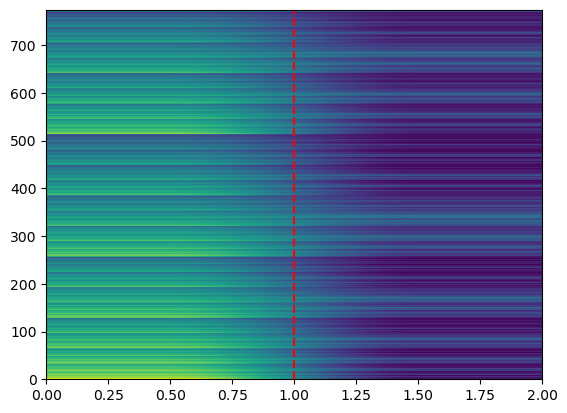

In [136]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D,Wraparound1D,periodic_padding,CustomCallback
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length,1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 

def balance_dataset(sequences):
    print(sequences.shape)
    count_ones = np.sum(sequences[:,-1:,:] == 1)
    count_zeros = np.sum(sequences[:,-1:,:] == 0)
    print(count_ones)
    print(count_zeros)
    ratio = count_zeros / count_ones 
    print(ratio)
    while ratio > 6 and len(x_train) > 0:
        print(ratio)
        for index,row in enumerate(sequences):
            row =row[1]
            zeros_per_row = np.sum(row == 0)
            ones_per_row = np.sum(row == 1)
            print(f"Ones per row: {ones_per_row}, Zeros per row: {zeros_per_row}")
            if( zeros_per_row >7):
                row_to_remove = np.argmax(zeros_per_row - ones_per_row)
                print(f"removing {index}")
                sequences = np.delete(sequences, index, axis=0)
                count_ones = np.sum(sequences[:,-1:,:] == 1)
                count_zeros = np.sum(sequences[:,-1:,:] == 0)
                ratio = count_zeros / count_ones 
                break
                
    return sequences



#Seedings and Config
SEED =3
print("Starting...")
#os.environ['PYTHONHASHSEED']=str(SEED)
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  
#random.seed(SEED)
#np.random.seed(SEED)
#tf.random.set_seed(SEED)
#tf.config.threading.set_inter_op_parallelism_threads(1)
 
gridsize=10
 
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]
x_values = [[int(bit) for bit in seq] for seq in x_values]




MEMORY_CONSTANT=1
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

gol.set_rule_number(32)

sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length-1))

#sequences=balance_dataset(sequences)
 

collapsed_sequences=collapse_sequences(sequences)
collapsed_sequences_2d = np.squeeze(collapsed_sequences, axis=-1)
plt.imshow(collapsed_sequences_2d, cmap='viridis', origin='upper',
           extent=[0, collapsed_sequences_2d.shape[1], 0, collapsed_sequences_2d.shape[0]],
           aspect='auto', vmin=0, vmax=gridsize)
for x in range(1, collapsed_sequences_2d.shape[1]):
    plt.axvline(x=x, color='red', linestyle='--')

np.random.shuffle(sequences)
x_sequence=sequences[:,MEMORY_CONSTANT-1:(MEMORY_CONSTANT)*2-1,:]
y_sequence=sequences[:,-1,:]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
x_train = x_sequence   
y_train= Y_val_onehot


split_ratio = 0.25
split_point = int(len(x_train) * split_ratio)
x_test = x_train[:split_point]
y_test = y_train[:split_point]
x_train = x_train[split_point:]
y_train = y_train[split_point:]
split_ratio = 0.5 
split_point = int(len(x_test) * split_ratio)
x_val = x_test[:split_point]
y_val = y_test[:split_point]
x_test = x_test[split_point:]
y_test = y_test[split_point:]
 
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape, "x_val shape:", x_val.shape, "y_val shape:", y_val.shape, "x_test shape:", x_test.shape, "y_test shape:", y_test.shape)


In [137]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


count_ones_x = np.sum(y_test == 1)
count_zeros_x = np.sum(y_test == 0)

count_ones_x, count_zeros_x

x_train shape: (581, 1, 10)
y_train shape: (581, 10, 2)
x_val shape: (96, 1, 10)
y_val shape: (96, 10, 2)
x_test shape: (97, 1, 10)
y_test shape: (97, 10, 2)


(970, 970)

# Regular 1D CA learned by a modified versison of the CNN-NIN architecture


In [151]:
memory_horizon=MEMORY_CONSTANT 
loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),
                                tf.reshape(y, shape=(-1, num_classes)),  from_logits=True)


model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  
model.add(Wraparound1D(padding=1))
model.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True,
                                 bias_initializer=tf.keras.initializers.Zeros()) )

model.add(tf.keras.layers.Conv1D(10, 1, activation='relu', padding='same',
                                bias_initializer=tf.keras.initializers.Zeros()))
 
model.add(tf.keras.layers.Dense(units=2, activation="softmax",
                                bias_initializer=tf.keras.initializers.Zeros()))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
              ,loss=loss, metrics=['accuracy'])

model.summary()
early_stopping_callback = CustomCallback()
 
x_train_reshaped=x_train.reshape(-1, gridsize,1)
model.fit(x_train_reshaped, y_train, 
          validation_data=(x_val.reshape(-1,gridsize,1 ), y_val),epochs=3
        , batch_size=1,callbacks=[early_stopping_callback]) 
accuracy=model.evaluate(x_test.reshape(-1, gridsize,1),y_test)
print(accuracy)


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound1d_26 (Wraparound  (None, 12, 1)            0         
 1D)                                                             
                                                                 
 conv1d_52 (Conv1D)          (None, 10, 10)            40        
                                                                 
 conv1d_53 (Conv1D)          (None, 10, 10)            110       
                                                                 
 dense_26 (Dense)            (None, 10, 2)             22        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
4/4 [==============================] - 0s 1ms/step - loss: 0.3274 - accuracy: 1.0000
[0.327412486076355, 1.0]


In [98]:
predictions=model.predict(x_train_reshaped)
#np.argmax(predictions[0],axis=1)
#preds=np.array(list(map(lambda x:np.round(x,axis=1),predictions))).squeeze()
#true=np.array(list(map(lambda x:np.argmax(x,axis=1),y_test))).squeeze()
index=1
for ind,prediction in enumerate(x_train_reshaped):
    print(np.argmax(prediction,axis=1))
    print(np.argmax(y_train[ind],axis=1))
    print("__________")
    
indices

24/24 [==============================] - 0s 783us/step
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 1 0 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 1 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 1 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 1 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 0 0 0 0 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 1 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 1 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1]
__________
[0 0 0 0 0

[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 1 0 0 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 0 1 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 1 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 0 1 0 1 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0

NameError: name 'indices' is not defined

1/1 [==============================] - 0s 105ms/step
[[1 0 1 0 0 0 0 0 1 0]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


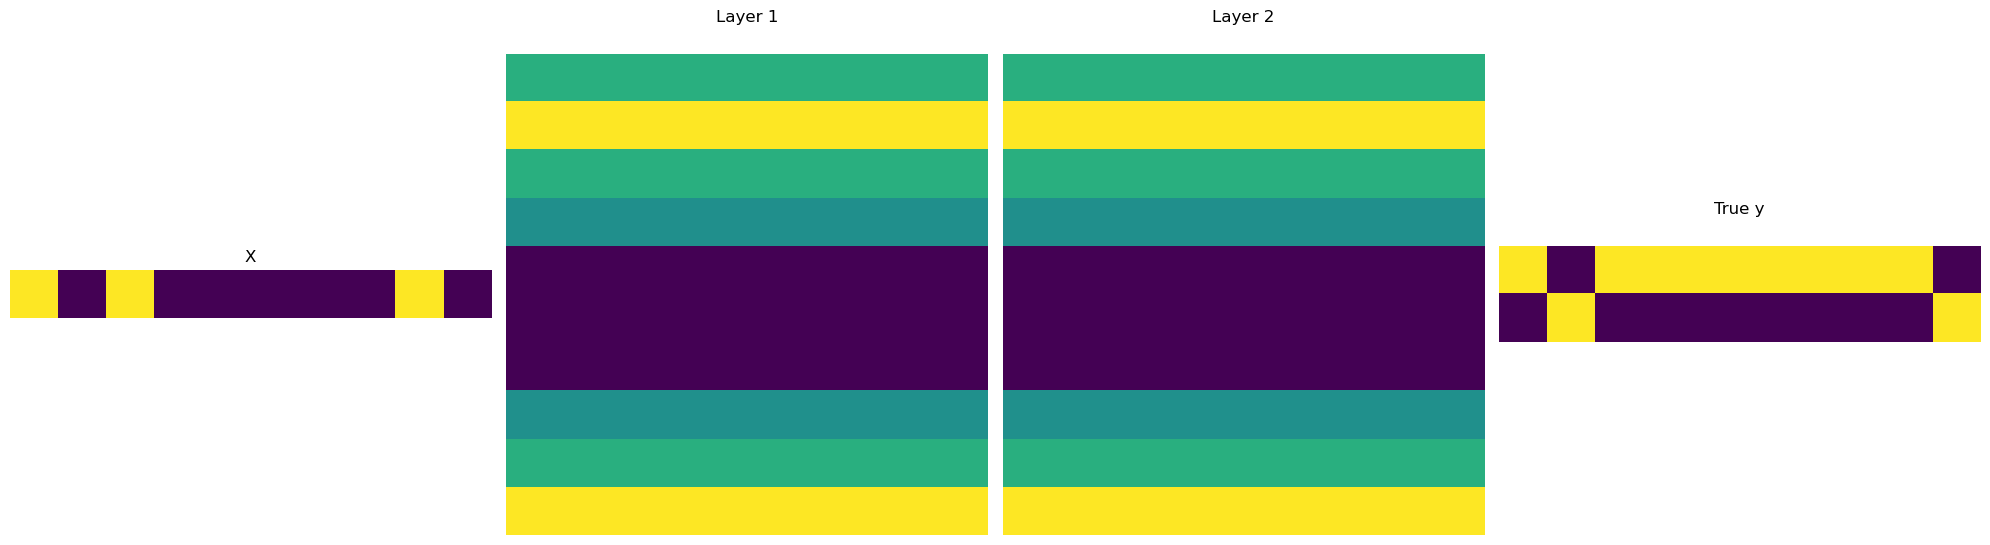

1/1 [==============================] - 0s 17ms/step
[[0 1 1 0 0 0 0 1 1 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


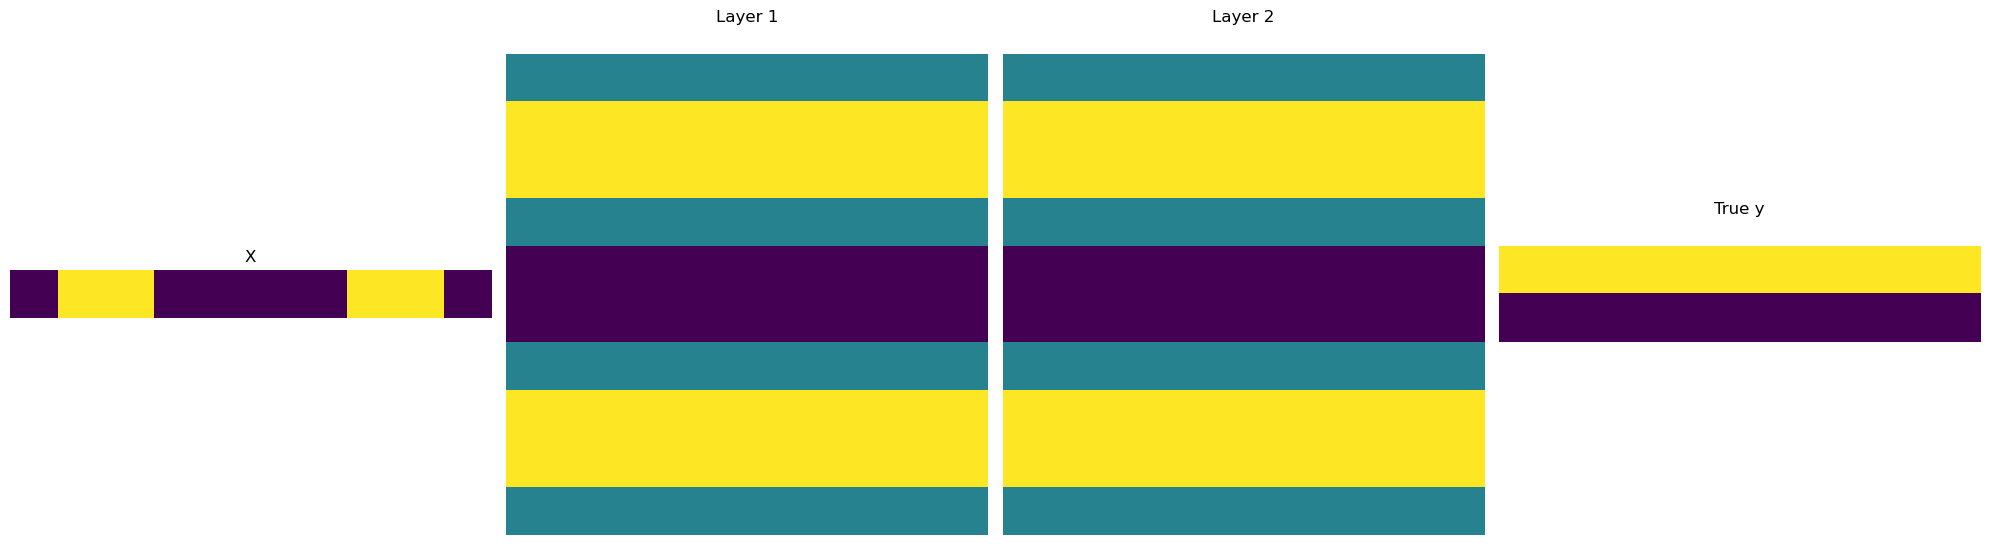

1/1 [==============================] - 0s 15ms/step
[[1 1 1 1 0 1 0 1 0 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


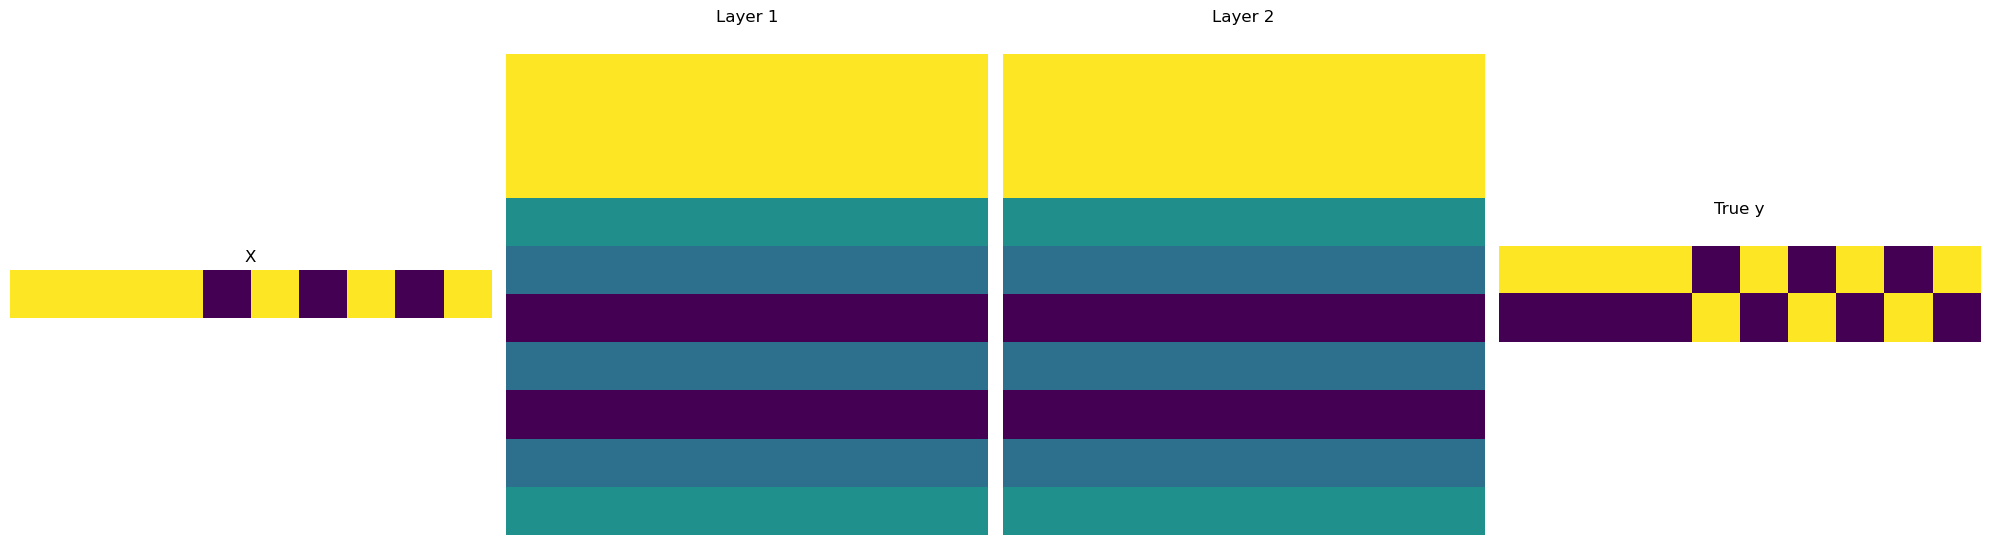

1/1 [==============================] - 0s 16ms/step
[[1 0 0 0 0 1 0 0 0 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


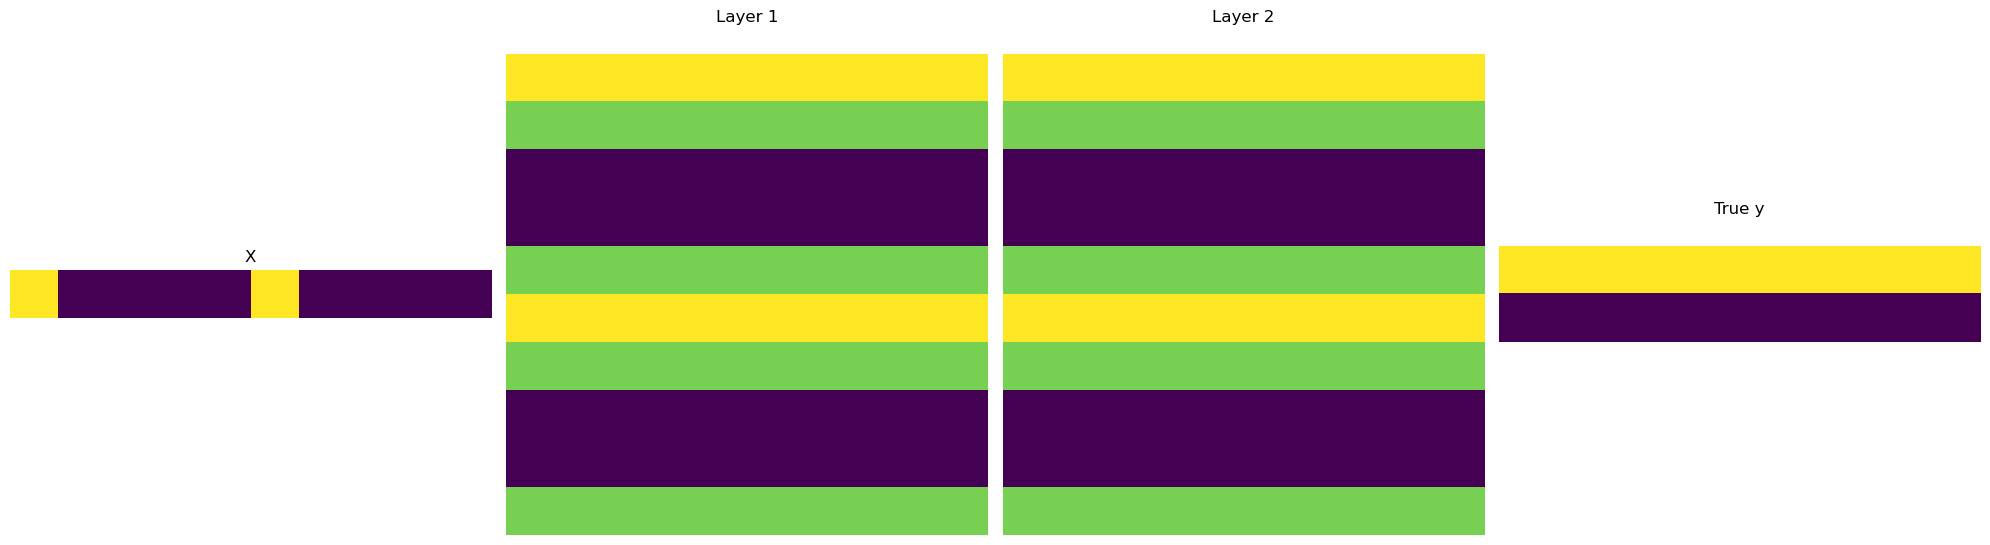

1/1 [==============================] - 0s 14ms/step
[[0 1 0 1 1 0 1 0 0 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


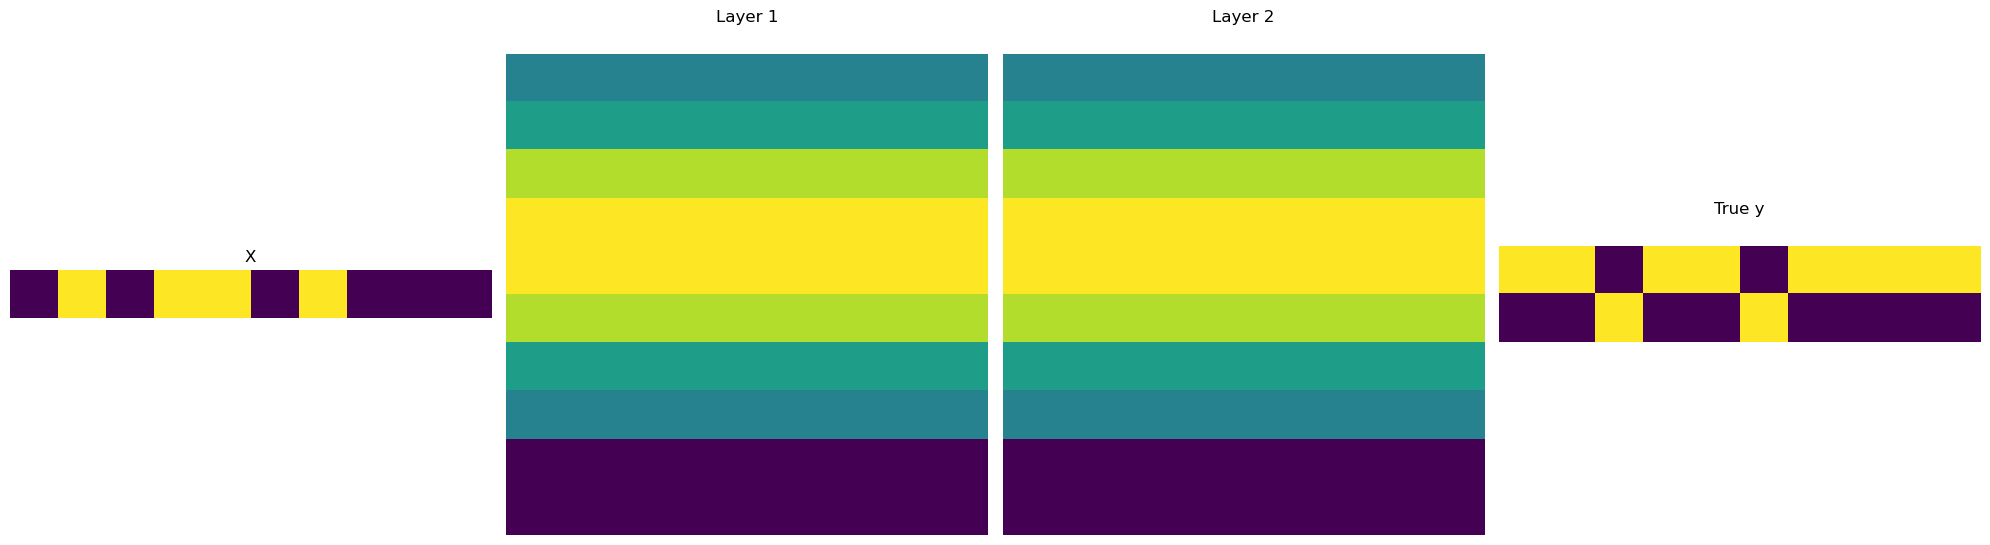

1/1 [==============================] - 0s 20ms/step
[[1 0 1 1 1 1 1 1 1 0]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


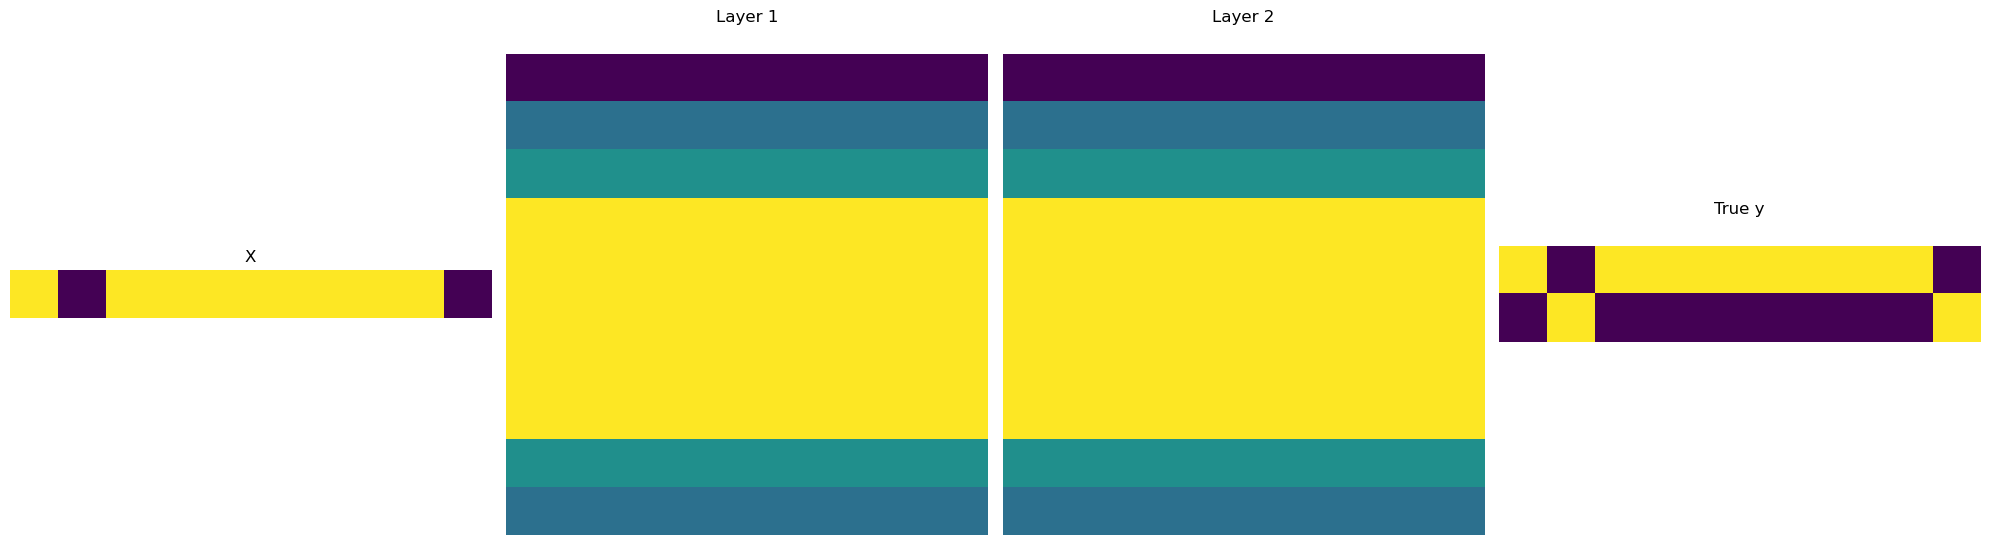

1/1 [==============================] - 0s 16ms/step
[[1 1 1 1 1 1 1 0 1 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


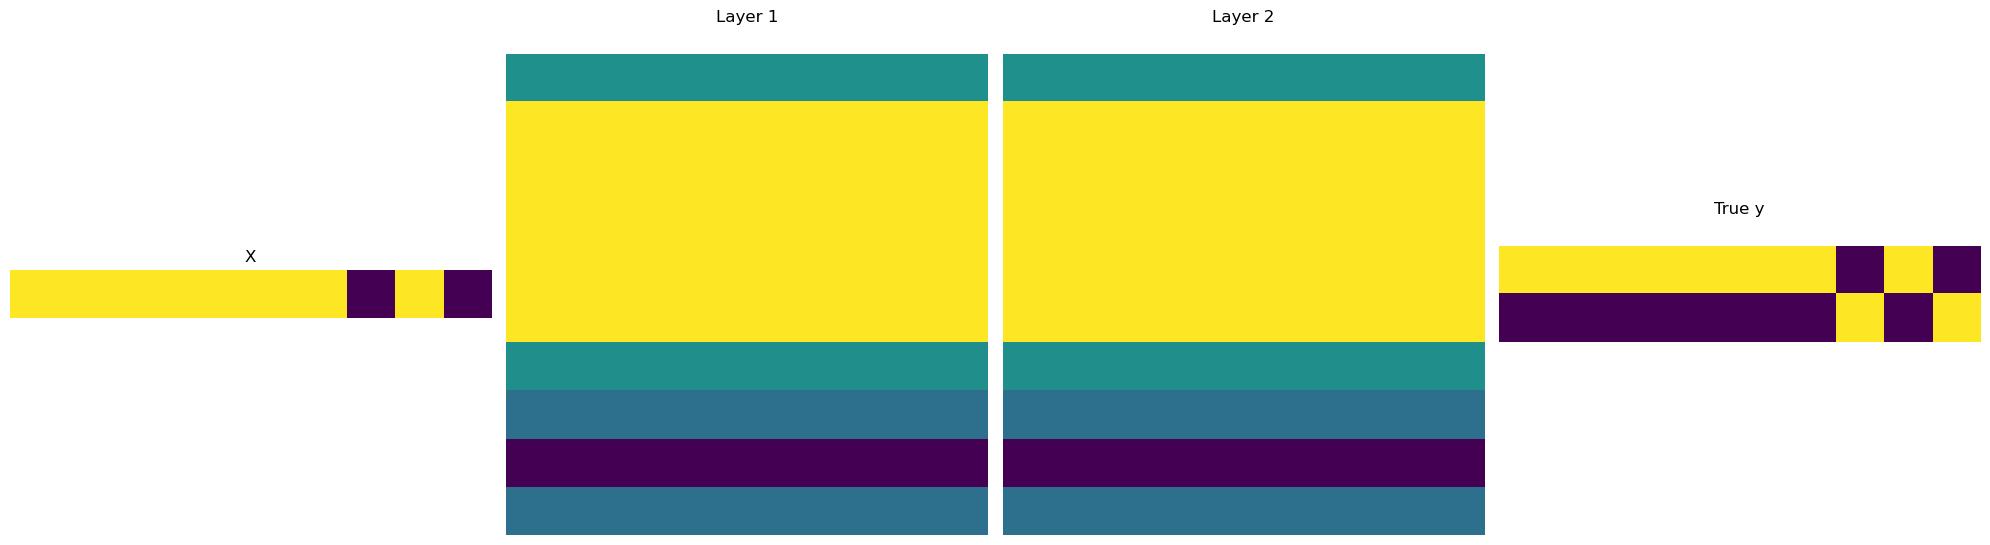

1/1 [==============================] - 0s 16ms/step
[[1 1 0 1 1 1 1 0 1 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


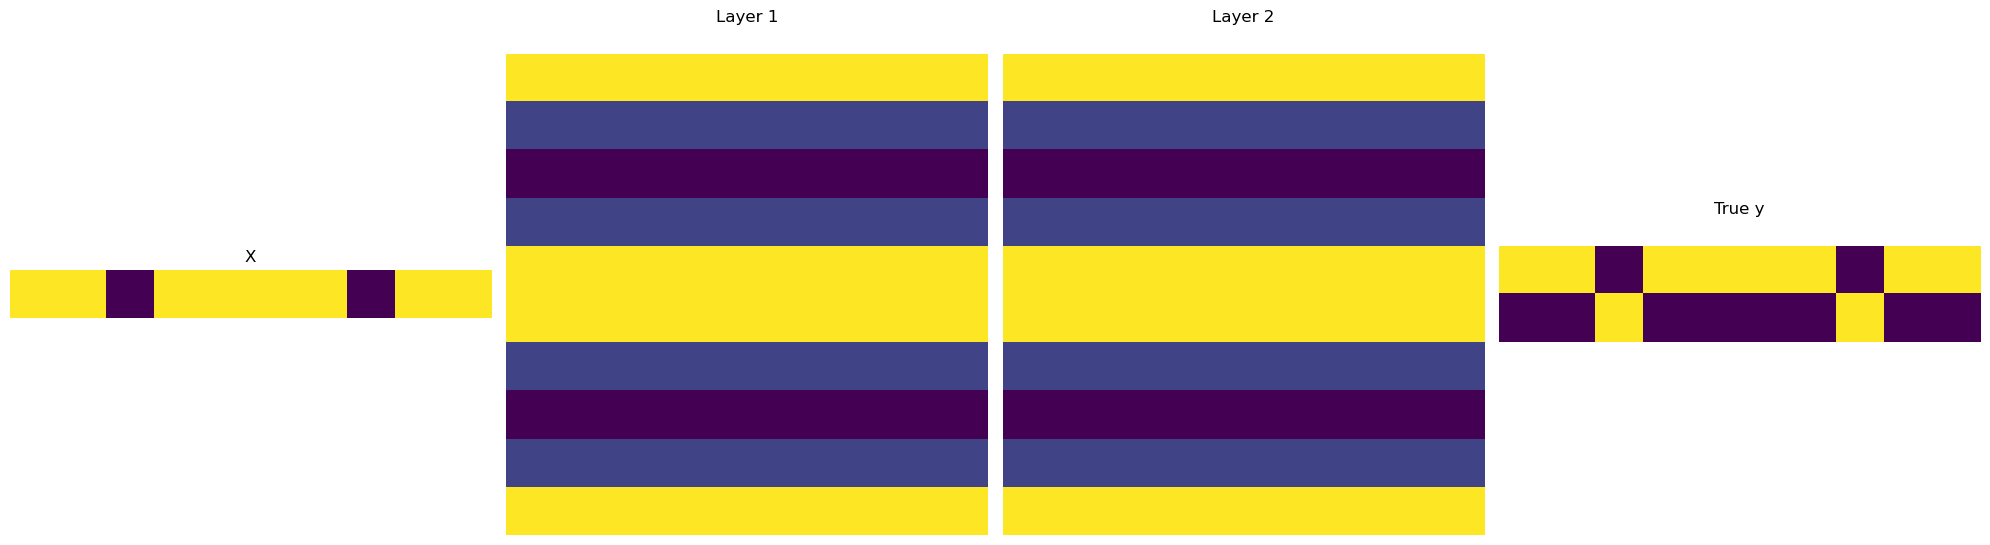

1/1 [==============================] - 0s 17ms/step
[[0 0 1 1 0 1 0 1 1 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


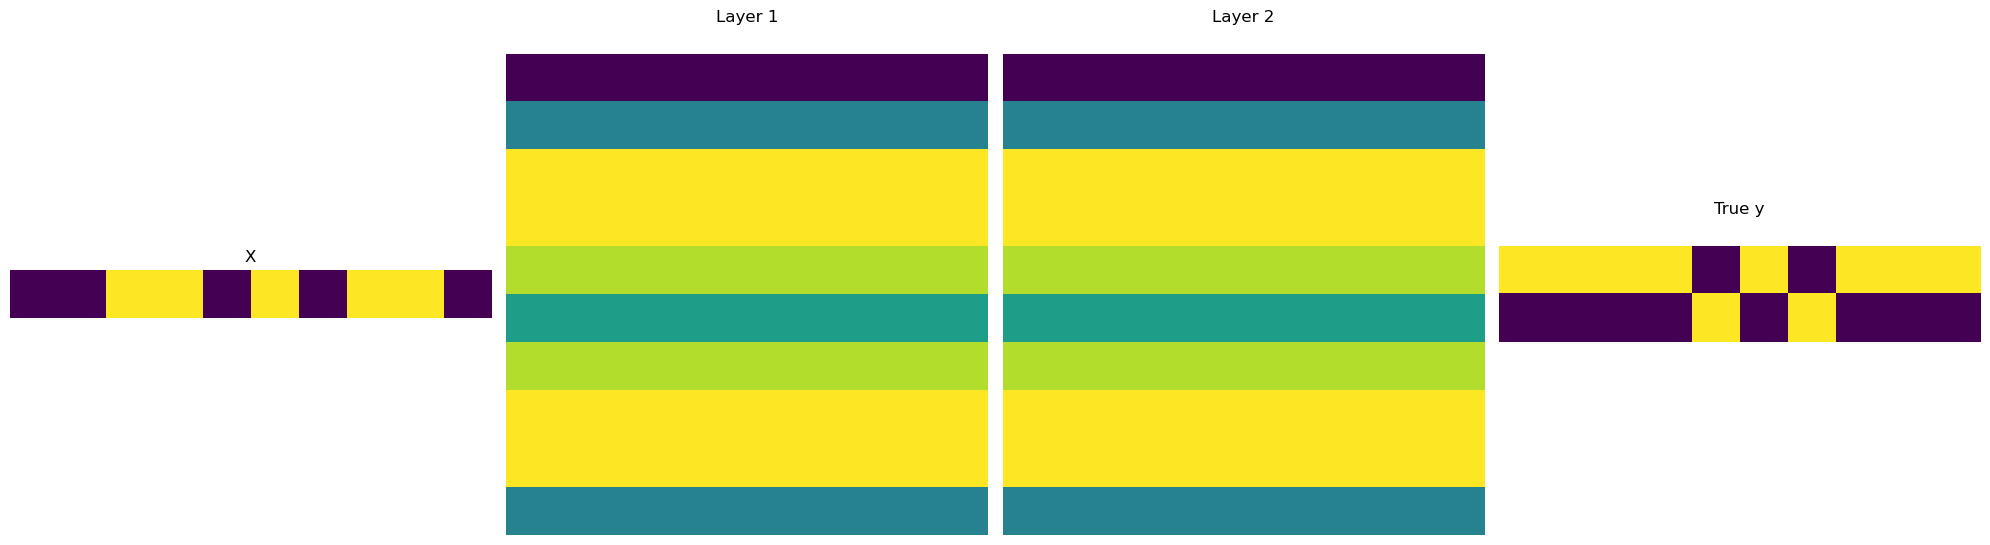

1/1 [==============================] - 0s 15ms/step
[[0 0 1 0 0 0 1 0 0 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


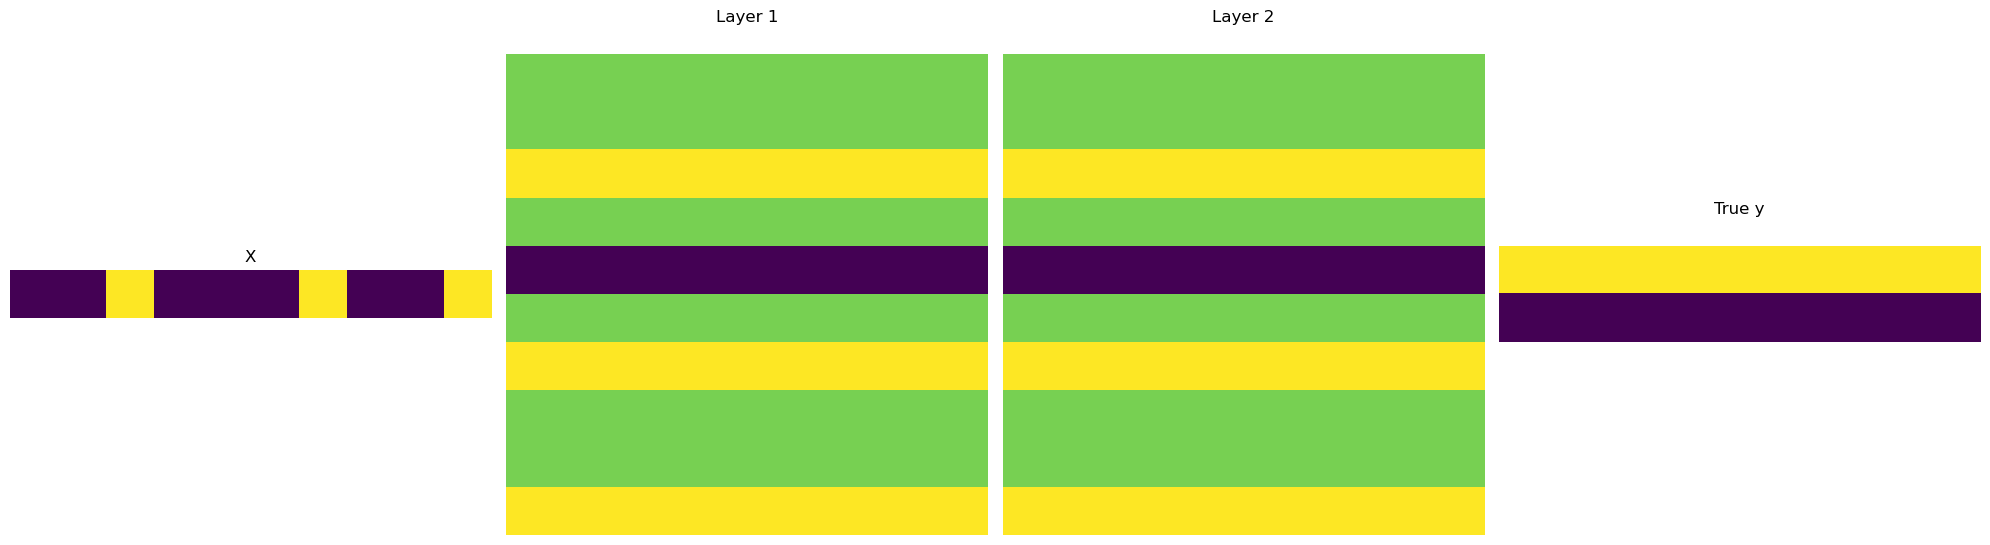

1/1 [==============================] - 0s 14ms/step
[[1 1 0 1 1 0 0 0 0 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


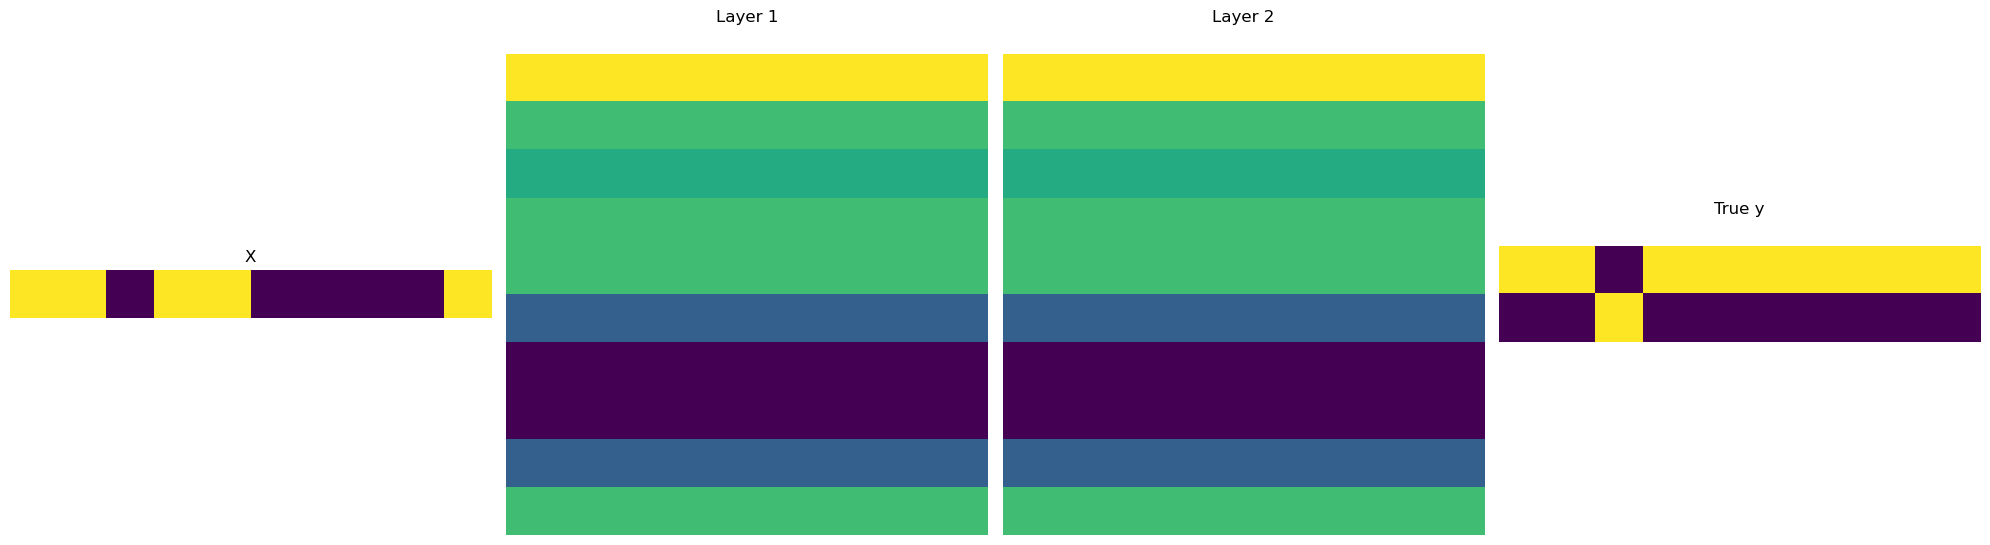

1/1 [==============================] - 0s 15ms/step
[[0 1 0 1 1 1 1 1 0 1]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


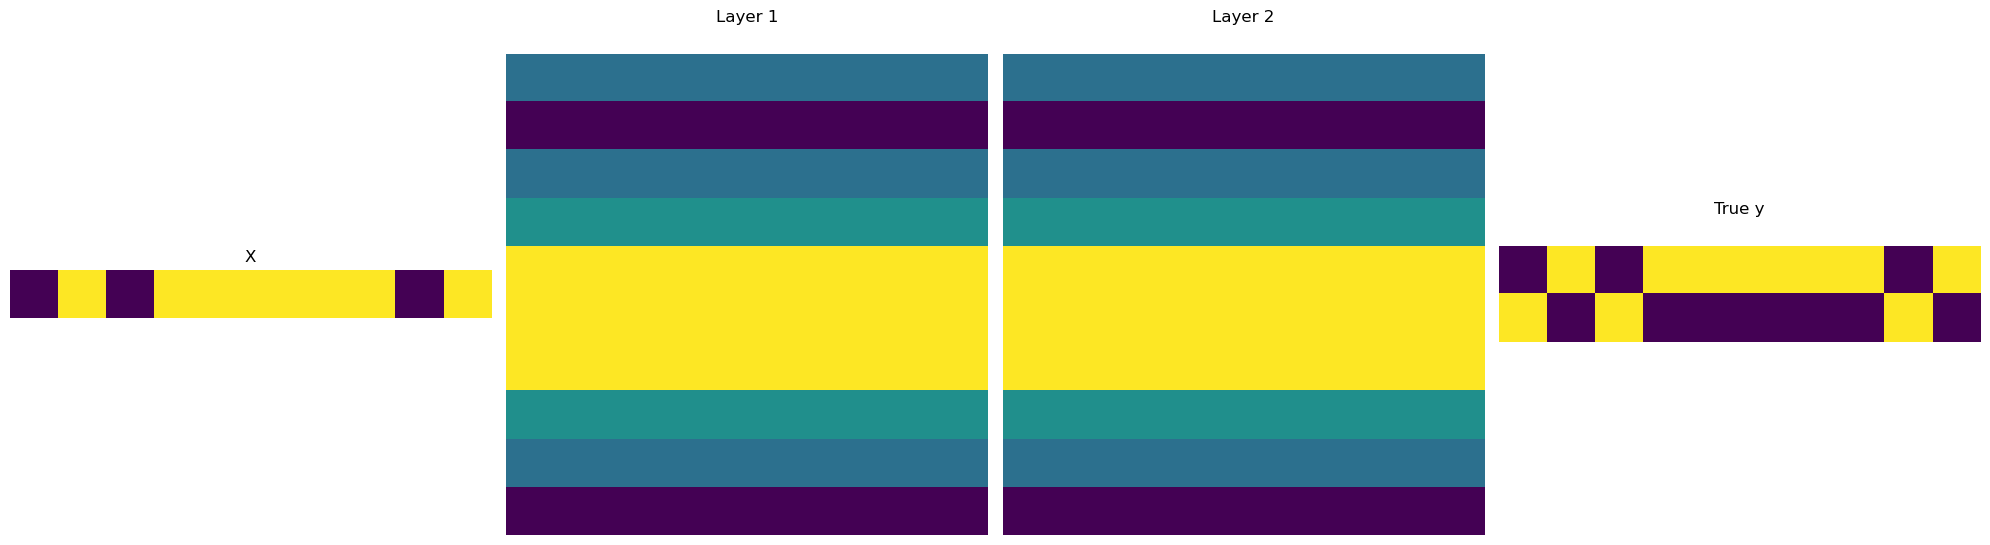

1/1 [==============================] - 0s 14ms/step
[[1 1 0 0 0 0 1 0 0 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


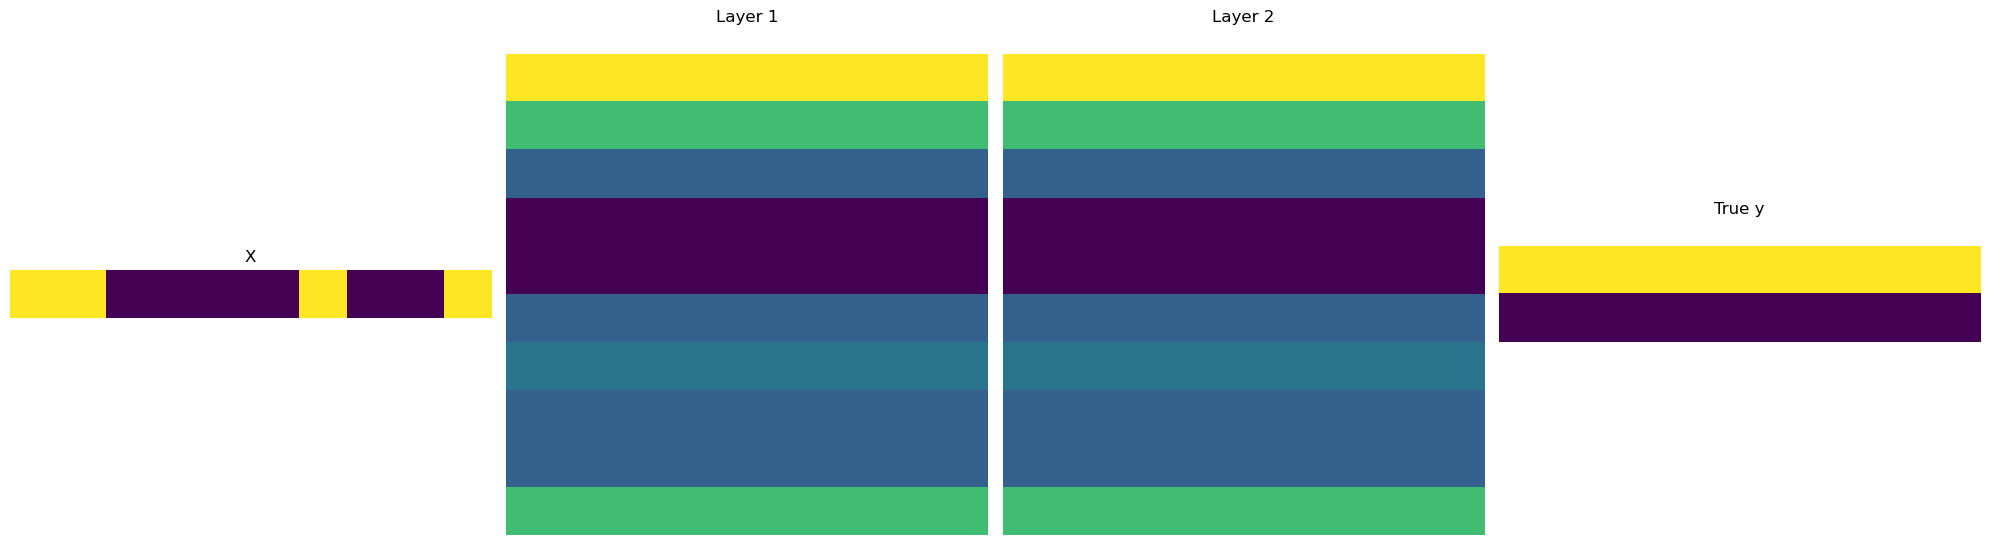

1/1 [==============================] - 0s 14ms/step
[[0 0 1 0 0 0 0 1 1 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


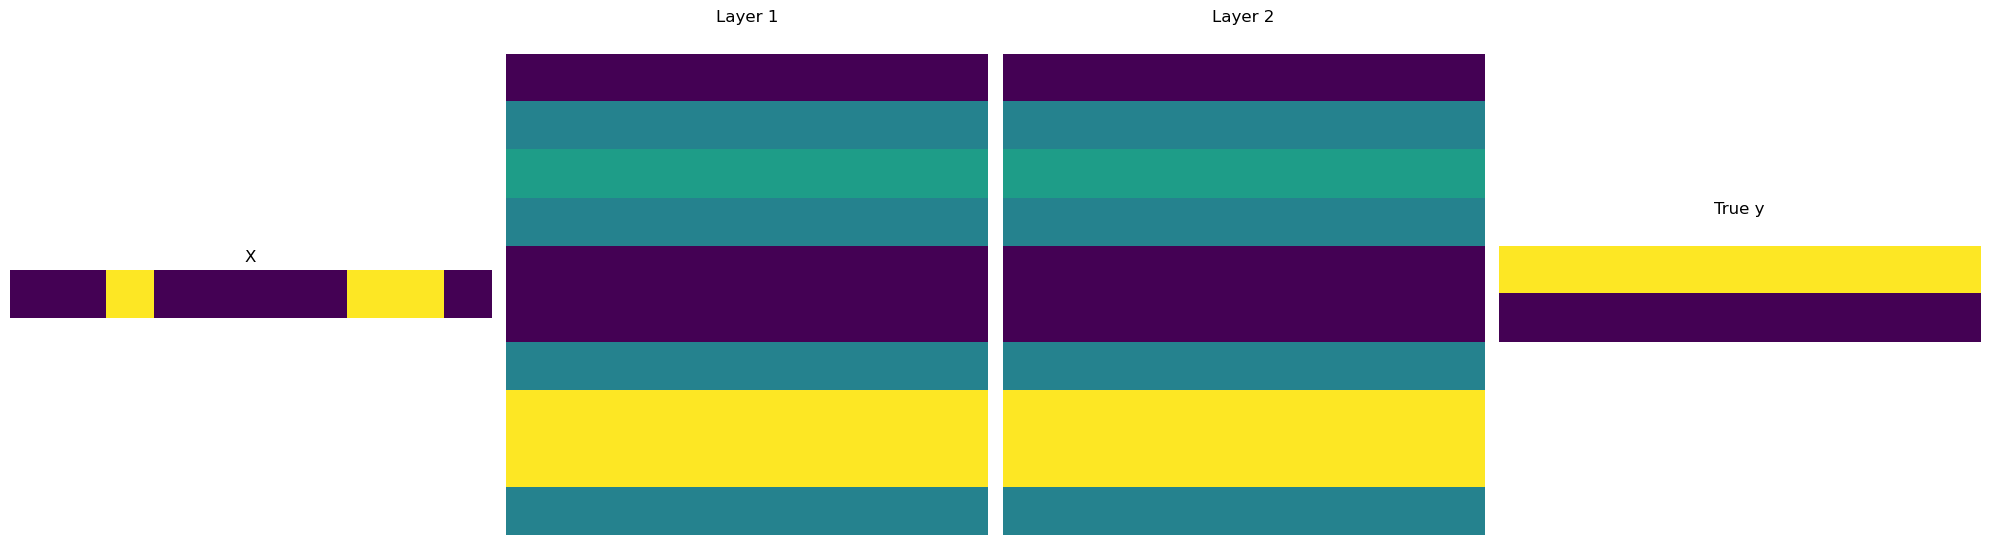

1/1 [==============================] - 0s 15ms/step
[[1 0 1 1 1 0 1 0 0 1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


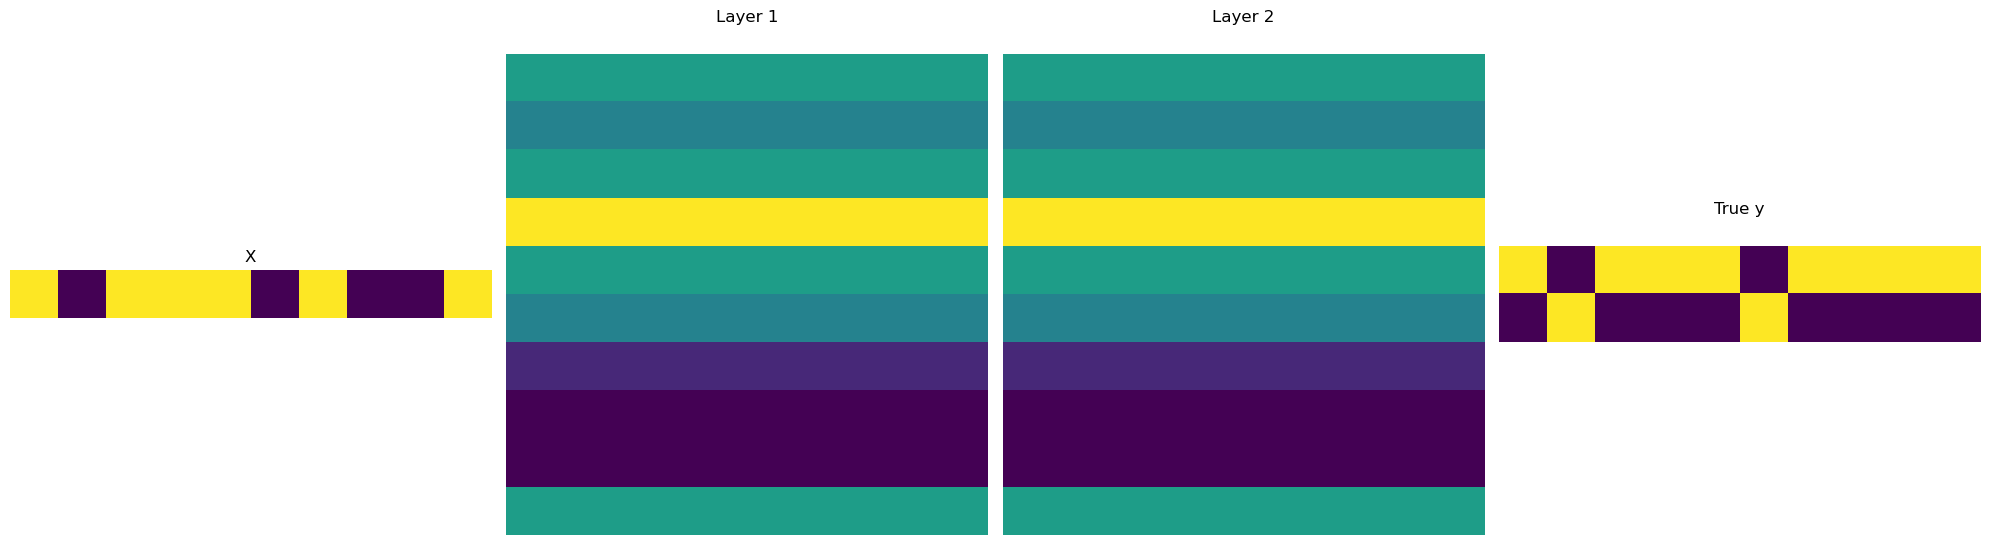

1/1 [==============================] - 0s 15ms/step
[[1 0 1 1 0 1 0 0 1 1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


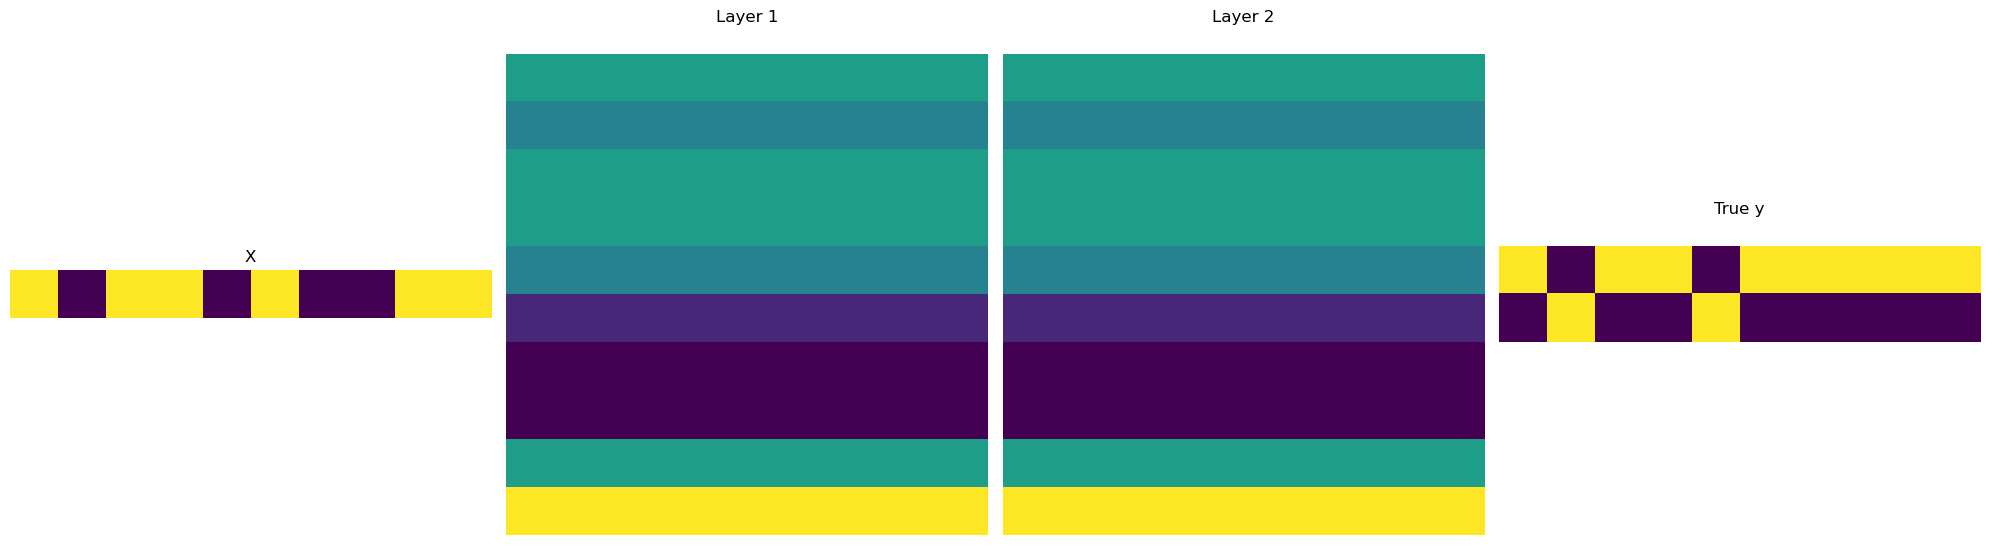

1/1 [==============================] - 0s 15ms/step
[[1 0 0 1 1 0 0 1 1 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


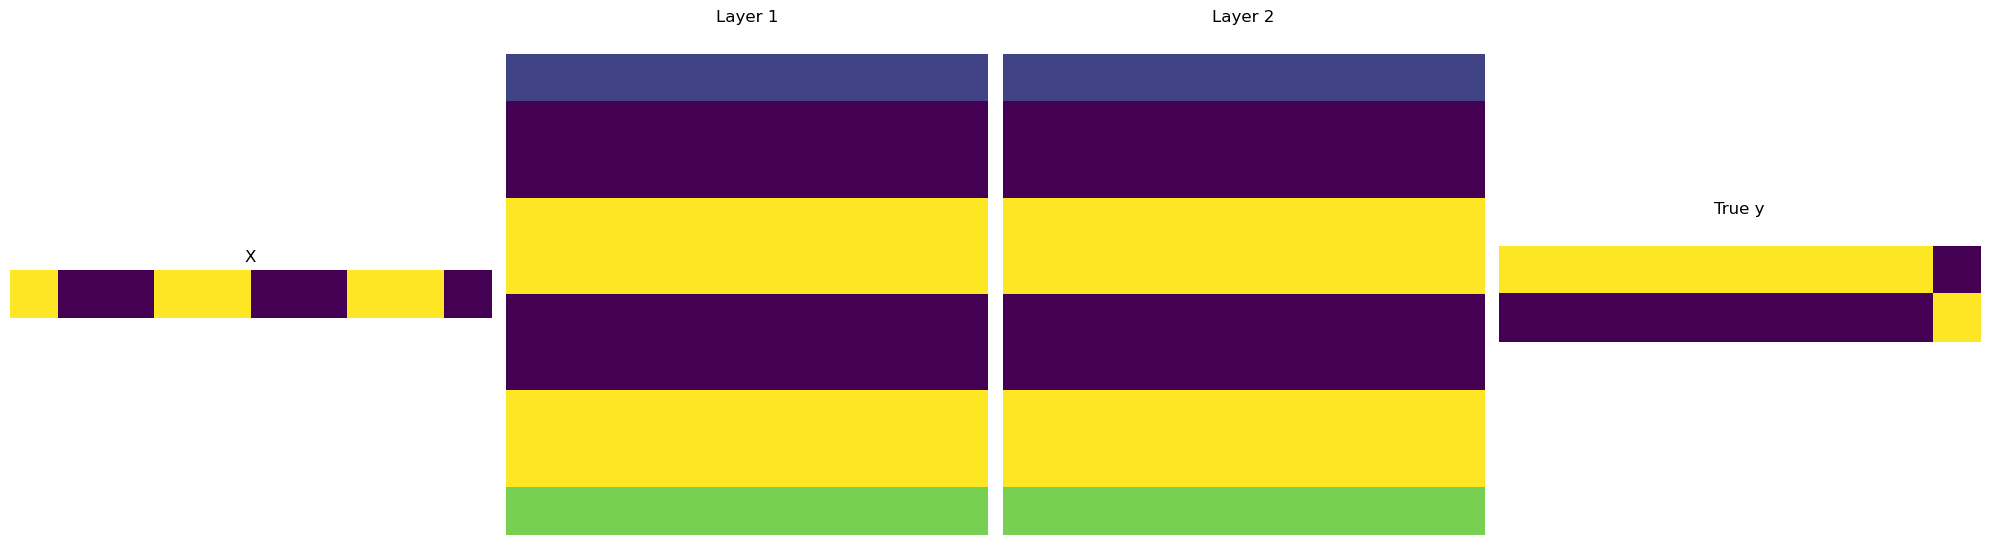

1/1 [==============================] - 0s 15ms/step
[[0 0 1 0 0 1 0 0 1 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


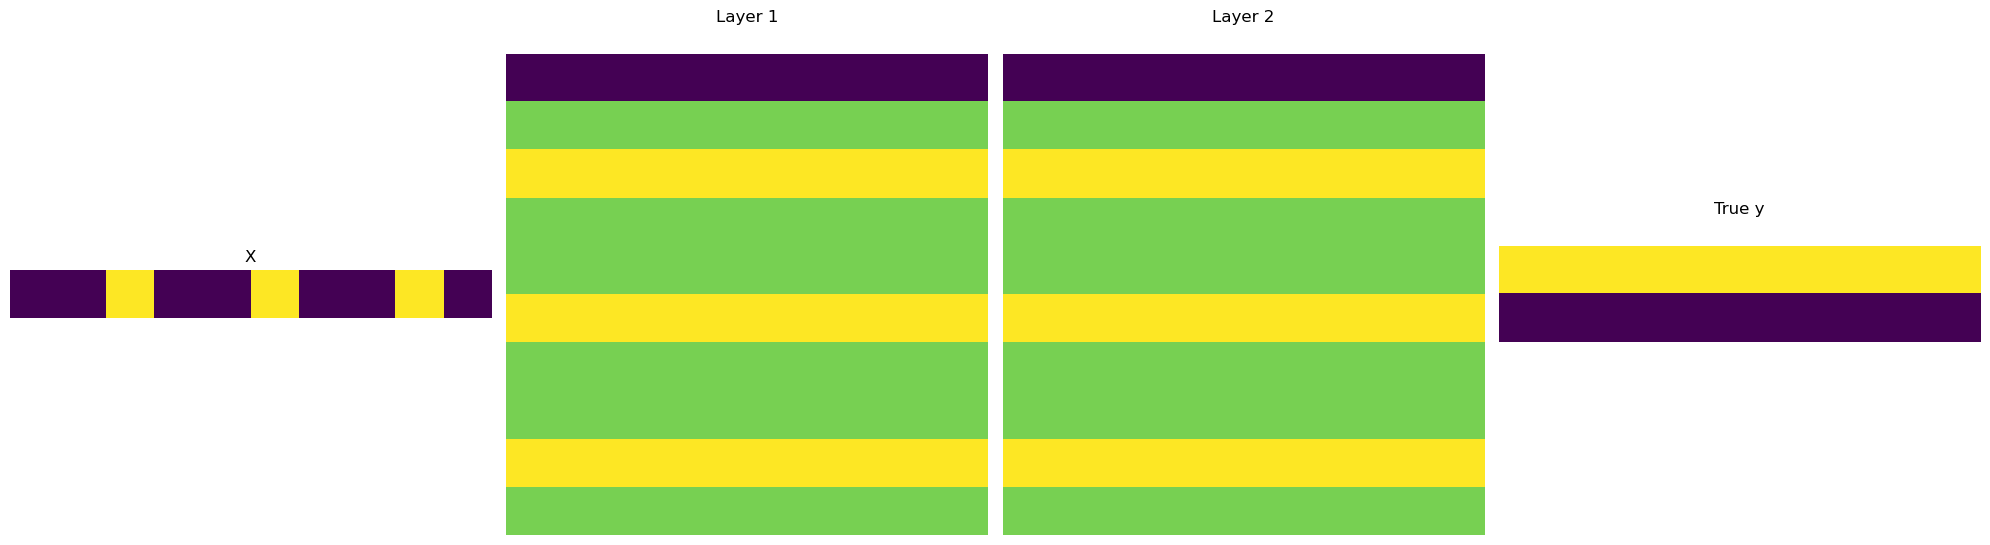

1/1 [==============================] - 0s 17ms/step
[[0 1 0 0 0 1 1 1 1 1]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


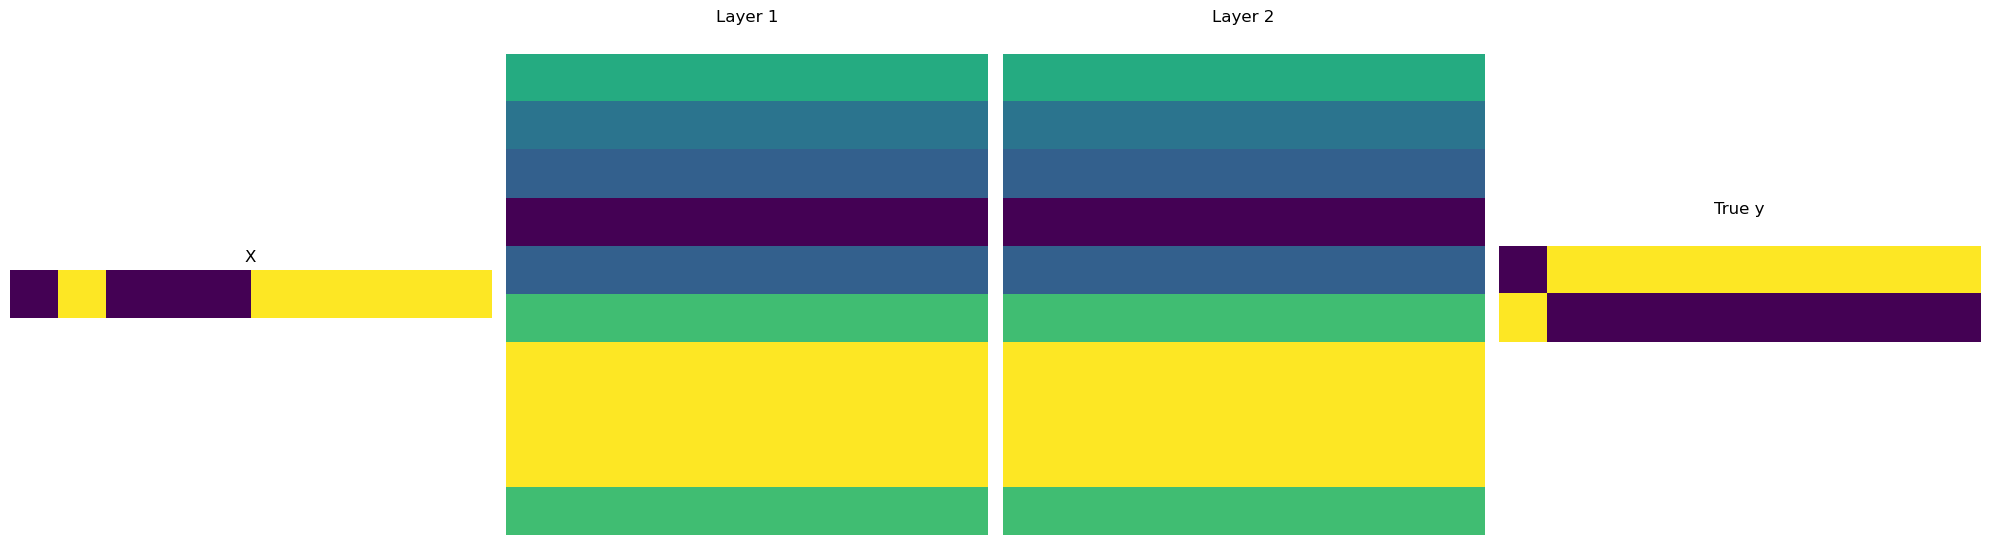

1/1 [==============================] - 0s 15ms/step
[[1 0 0 0 0 0 1 0 1 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


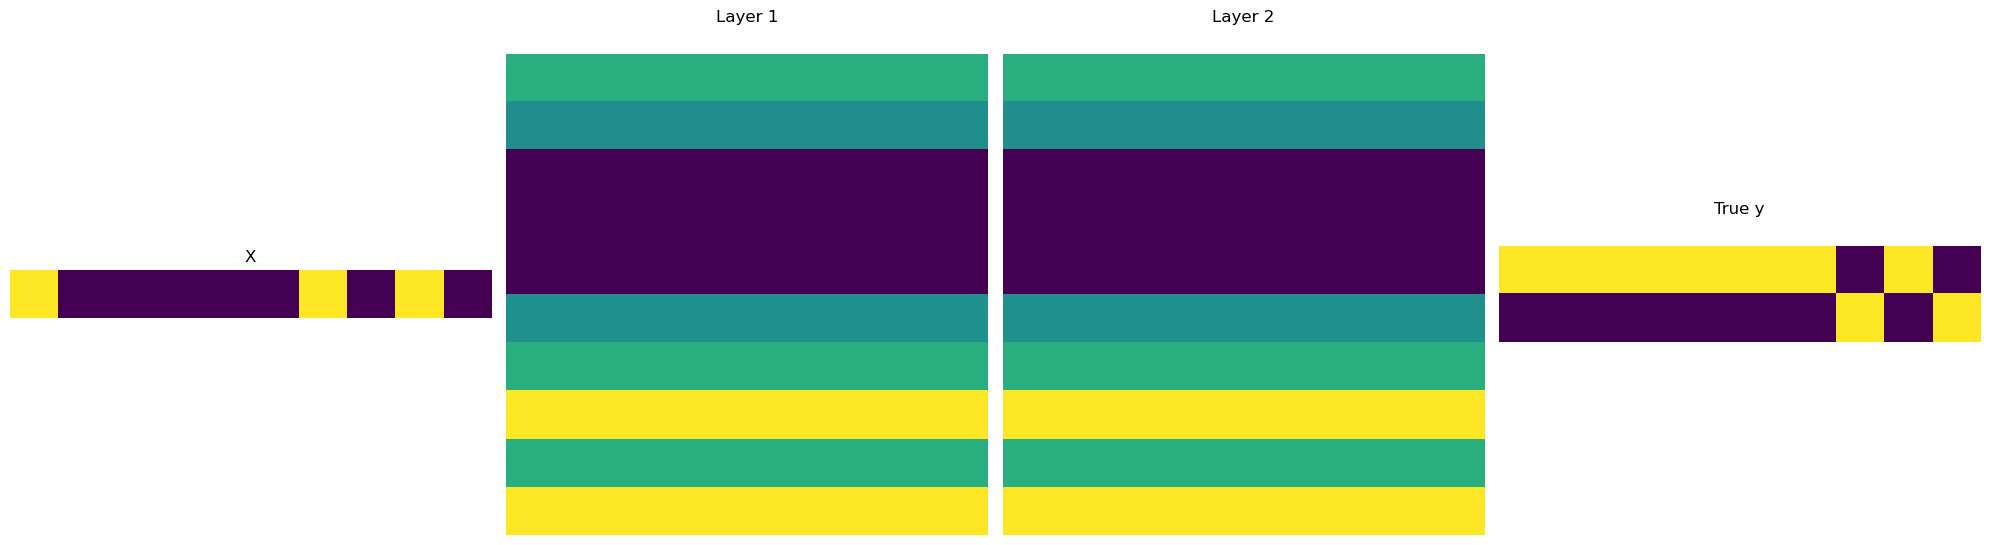

In [99]:
from tensorflow.keras.models import Model


# List to store the output of convolutional layers
conv_layer_outputs = [layer.output for layer in model.layers if "conv" in layer.name.lower()]

# Create a new model that outputs the activations for every convolutional layer
activation_model = Model(inputs=model.input, outputs=conv_layer_outputs)

for ind, x in enumerate(x_train_reshaped[0:20]):
    x_to_visualize = np.expand_dims(x, axis=0)

    # Get activations and round them
    activations = activation_model.predict(x_to_visualize)
   # activations = [np.round(act) for act in activations]

    # Get the output from the original model and round it
   # model_output = np.round(model.predict(x_to_visualize))
    model_output =model.predict(x_to_visualize)
    # Create a subplot for input + last two activations + output
    num_layers = len(activations)
    fig, axes = plt.subplots(1,4, figsize=(20, 20))

    # Plot input
    axes[0].imshow(x_to_visualize[0, :].transpose(), cmap="viridis")
    axes[0].set_title("X")
    axes[0].axis("off")


    for i, activation in enumerate(activations[-2:]):
        ax = axes[i + 1]
        ax.matshow(activation[0, :, :], cmap="viridis")
        ax.set_title(f"Layer {num_layers - 1 + i}")
        ax.axis("off")
    
    # prediction
   #axes[-2].matshow(model_output.transpose(), cmap="viridis")
   #axes[-2].set_title("Prediction")
   #axes[-2].axis("off")
    print(x_train[ind])
    print(y_train[ind])
    axes[-1].matshow(np.array(y_train[ind]).transpose(), cmap="viridis")
    axes[-1].set_title("True y")
    axes[-1].axis("off")

    plt.tight_layout()

    #'plt.savefig("Recurrentmem3activations" + str(ind) + ".png", dpi=300, bbox_inches="tight")
    plt.show()


In [28]:

for i in range (0,256):
    gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                    memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

    gol.set_rule_number(i)
    data=gol.generate_train_test_validation()
    x_train=data[0]
    y_train=data[1]
    x_val=data[2]
    y_val=data[3]
    x_test=data[4]
    y_test=data[5]
    memory_horizon=MEMORY_CONSTANT# is equal to 1
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
    model.add(Wraparound1D(padding=1))
    model.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True) )

    model.add(tf.keras.layers.Conv1D(10, 1, activation='relu', padding='same'))

    model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                    kernel_initializer=tf.keras.initializers.Ones(), 
                                    bias_initializer=tf.keras.initializers.he_normal()))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
    model.summary()
    early_stopping_callback = CustomCallback()

    x_train_reshaped=x_train.reshape(-1, gridsize,1)
    model.fit(x_train_reshaped, y_train, 
              validation_data=(x_val.reshape(-1,gridsize,1 ), y_val),epochs=3
            , batch_size=1,callbacks=[early_stopping_callback]) 
    eval=model.evaluate(x_test.reshape(-1, gridsize,1),y_test)
    if(eval[1]==1):
        

ValueError: in user code:

    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 30, 1), found shape=(None, 250, 3, 10)


In [24]:
array_3d = x_sequence

num_zeros = np.count_nonzero(array_3d == 0)
num_ones = np.count_nonzero(array_3d == 1)

# Calculate the ratio of 0s to 1s
if num_ones != 0:
    ratio_zeros_to_ones = num_zeros / num_ones
else:
    ratio_zeros_to_ones = float('inf')  

print("Number of 0s:", num_zeros)
print("Number of 1s:", num_ones)
print("Ratio of 0s to 1s:", ratio_zeros_to_ones)

Number of 0s: 105087
Number of 1s: 104913
Ratio of 0s to 1s: 1.00165851705699


In [74]:
shape=(10,10)
layer_dims=[10,10]
nhood=1 
num_classes=2
totalistic=False
nhood_type="moore"
bc="same"

wspan, hspan = shape
diameter = 2*nhood+1
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer((wspan, hspan, 1)))
 
for i in range(1, len(layer_dims)):
    model.add(tf.keras.layers.Dense(layer_dims[i],  activation='relu',
                                    kernel_initializer=tf.keras.initializers.Ones(), 
                                    bias_initializer=tf.keras.initializers.he_normal()))
model.add(tf.keras.layers.Dense(2,  activation='softmax'))
model.add(tf.keras.layers.Dense(2,  activation='softmax'))
#model.add(tf.keras.layers.Reshape(target_shape=(-1, wspan, hspan)))
 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...


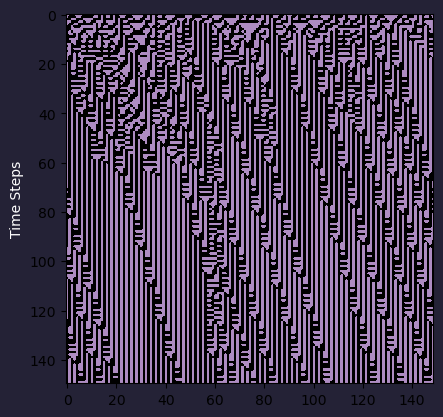

[0.4563758389261745, 0.5100671140939598, 0.5234899328859061, 0.5436241610738255, 0.4563758389261745, 0.5100671140939598, 0.5100671140939598, 0.47651006711409394, 0.5771812080536913, 0.5100671140939598, 0.5234899328859061, 0.5369127516778524, 0.5436241610738255, 0.6040268456375839, 0.5100671140939598, 0.5369127516778524, 0.5369127516778524, 0.5234899328859061, 0.5100671140939598, 0.46308724832214765, 0.5436241610738255, 0.5033557046979866, 0.5302013422818792, 0.5369127516778524, 0.5503355704697986, 0.5302013422818792, 0.5771812080536913, 0.47651006711409394, 0.610738255033557, 0.4563758389261745, 0.5369127516778524, 0.5167785234899329, 0.5302013422818792, 0.5503355704697986, 0.48322147651006714, 0.5234899328859061, 0.5302013422818792, 0.5570469798657718, 0.5234899328859061, 0.5570469798657718, 0.5234899328859061, 0.5436241610738255, 0.5033557046979866, 0.5570469798657718, 0.4697986577181208, 0.5369127516778524, 0.5167785234899329, 0.5503355704697986, 0.5033557046979866, 0.52348993288590

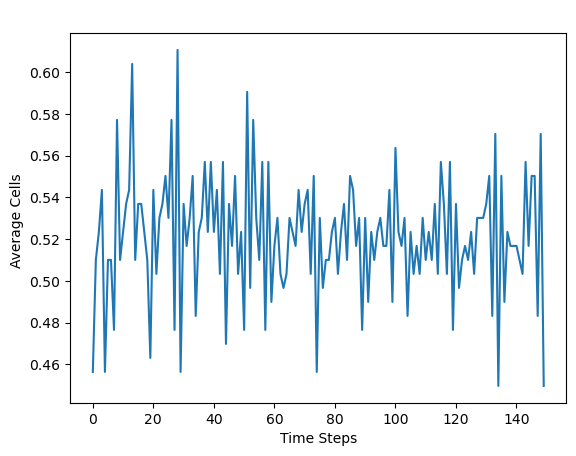

<Figure size 640x480 with 0 Axes>

In [8]:
random.seed(SEED)
np.random.seed(SEED)
gridsize=149
x_values = [seq for seq in itertools.product("01", repeat=10)]
x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=6
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT,initial_state=x_value)

gol.set_rule([[[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1]],
              [[0],      [1]         ,[1]      ,[1]     ,[1]      ,[0]      ,[0],     [0 ]]])

gol.step_multiple(149)
gol.render_state()
gol.plot_evolultion()
plt.savefig('rule300.png')